**research paper v1**: Swin Transformer: Hierarchical Vision Transformer using Shifted Windows; https://arxiv.org/pdf/2103.14030

**research paper v2**: Swin Transformer V2: Scaling Up Capacity and Resolution:https://arxiv.org/pdf/2111.09883

# **Architecture**

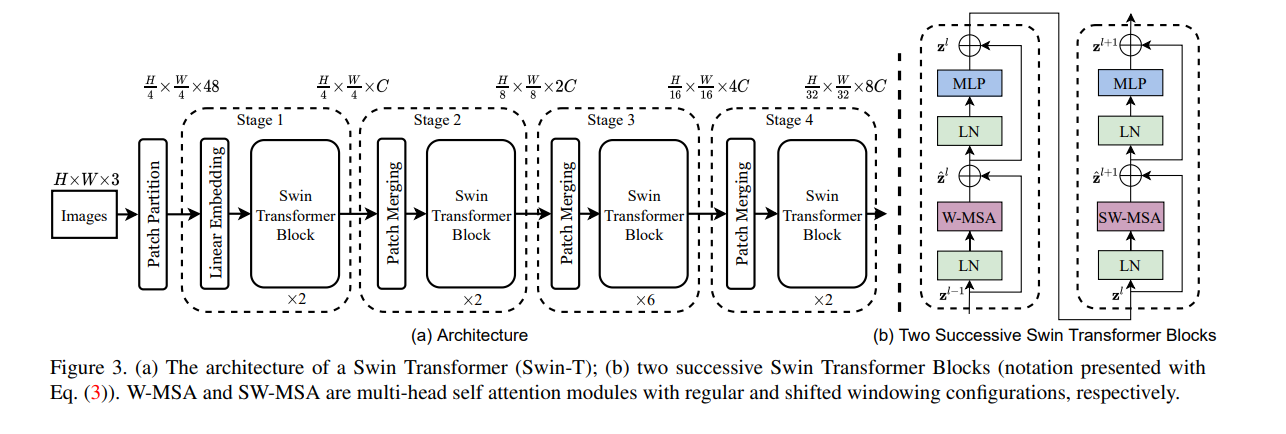

**Import important libraries**

In [17]:
import torch
from torch import nn, einsum
import numpy as np
from einops import rearrange, repeat

# **Different variants of Swin transformers**

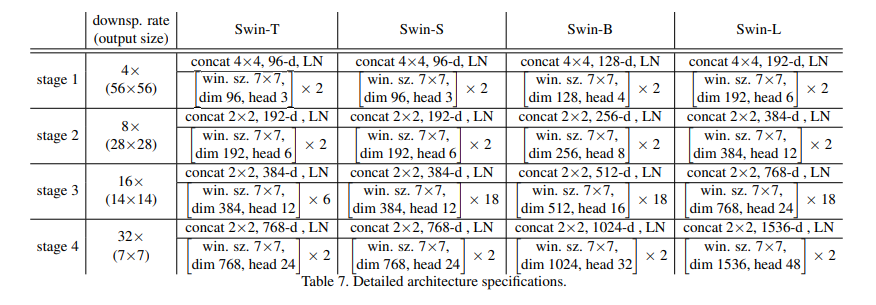

In [18]:
def swin_t(hidden_dim=96, layers=(2, 2, 6, 2), heads=(3, 6, 12, 24), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)

In [19]:
def swin_s(hidden_dim=96, layers=(2, 2, 18, 2), heads=(3, 6, 12, 24), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)

In [20]:
def swin_b(hidden_dim=128, layers=(2, 2, 18, 2), heads=(4, 8, 16, 32), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)

In [21]:
def swin_l(hidden_dim=192, layers=(2, 2, 18, 2), heads=(6, 12, 24, 48), **kwargs):
    return SwinTransformer(hidden_dim=hidden_dim, layers=layers, heads=heads, **kwargs)

**kwargs: This allows passing additional arguments to the SwinTransformer class, making the functions flexible. For instance, arguments like dropout rate or positional embeddings might be passed without explicitly defining them in these functions.

# **Swin Transformer**

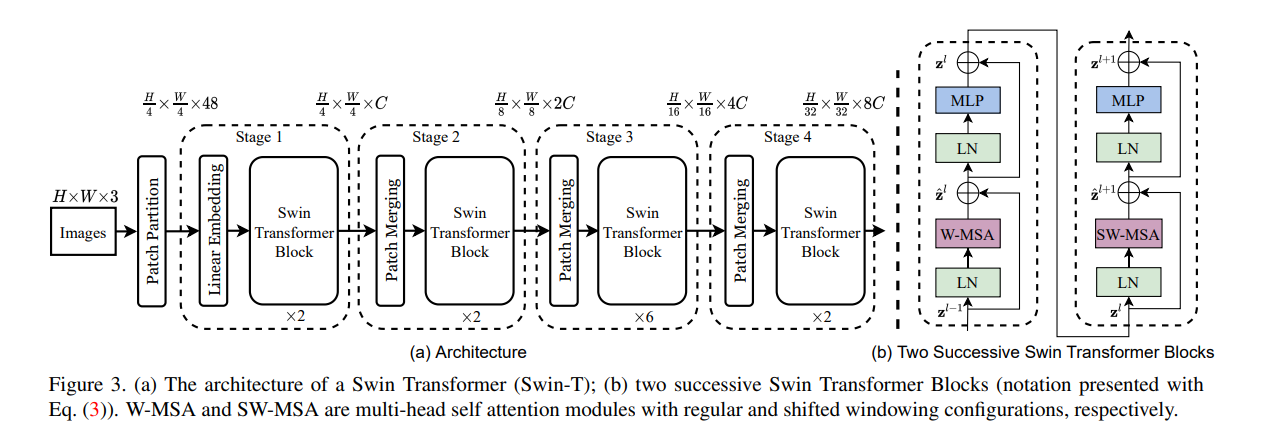

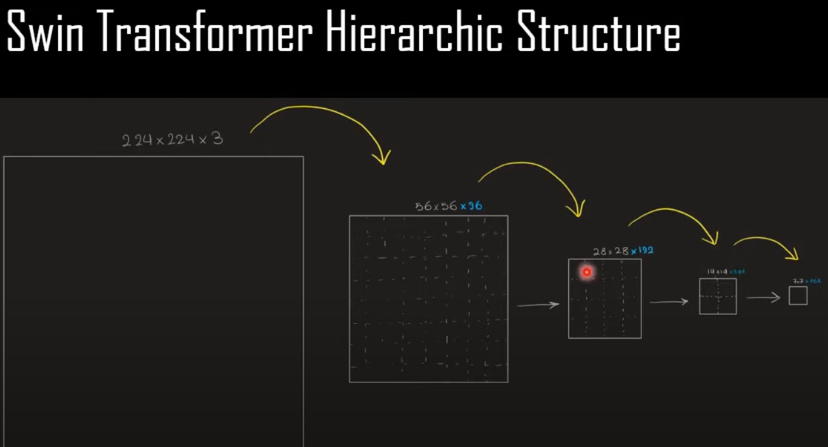

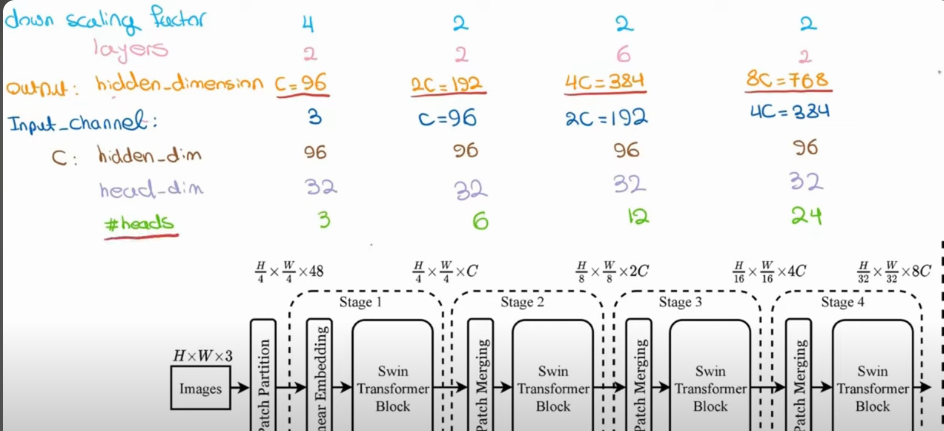

In [22]:
class SwinTransformer(nn.Module):
    def __init__(self, *, hidden_dim, layers, heads, channels=3, num_classes=1000, head_dim=32, window_size=7,
                 downscaling_factors=(4, 2, 2, 2), relative_pos_embedding=True):
        super().__init__()

        self.stage1 = StageModule(in_channels=channels, hidden_dimension=hidden_dim, layers=layers[0],
                                  downscaling_factor=downscaling_factors[0], num_heads=heads[0], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage2 = StageModule(in_channels=hidden_dim, hidden_dimension=hidden_dim * 2, layers=layers[1],
                                  downscaling_factor=downscaling_factors[1], num_heads=heads[1], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage3 = StageModule(in_channels=hidden_dim * 2, hidden_dimension=hidden_dim * 4, layers=layers[2],
                                  downscaling_factor=downscaling_factors[2], num_heads=heads[2], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)
        self.stage4 = StageModule(in_channels=hidden_dim * 4, hidden_dimension=hidden_dim * 8, layers=layers[3],
                                  downscaling_factor=downscaling_factors[3], num_heads=heads[3], head_dim=head_dim,
                                  window_size=window_size, relative_pos_embedding=relative_pos_embedding)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(hidden_dim * 8),
            nn.Linear(hidden_dim * 8, num_classes)
        )

    def forward(self, img):
        x = self.stage1(img)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = x.mean(dim=[2, 3])
        return self.mlp_head(x)

# **StageModule**

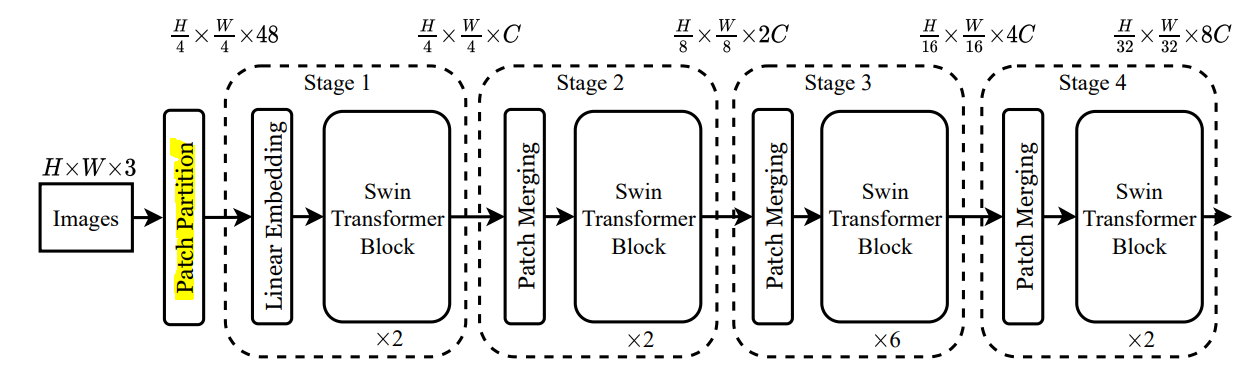

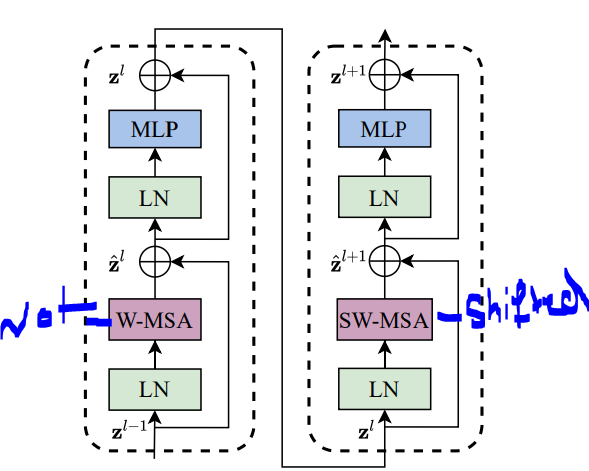

In [23]:
class StageModule(nn.Module):
    def __init__(self, in_channels, hidden_dimension, layers, downscaling_factor, num_heads, head_dim, window_size,
                 relative_pos_embedding):
        super().__init__()
        assert layers % 2 == 0, 'Stage layers need to be divisible by 2 for regular and shifted block.'

        self.patch_partition = PatchMerging(in_channels=in_channels, out_channels=hidden_dimension,
                                            downscaling_factor=downscaling_factor)

        self.layers = nn.ModuleList([])
        for _ in range(layers // 2):
            self.layers.append(nn.ModuleList([
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=False, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
                SwinBlock(dim=hidden_dimension, heads=num_heads, head_dim=head_dim, mlp_dim=hidden_dimension * 4,
                          shifted=True, window_size=window_size, relative_pos_embedding=relative_pos_embedding),
            ]))

    def forward(self, x):
        x = self.patch_partition(x)
        for regular_block, shifted_block in self.layers:
            x = regular_block(x)
            x = shifted_block(x)
        return x.permute(0, 3, 1, 2)

# **PatchMerging**

In [24]:
class PatchMerging(nn.Module):
    def __init__(self, in_channels, out_channels, downscaling_factor):
        super().__init__()

        # Store the downscaling factor, which is used for extracting patches
        self.downscaling_factor = downscaling_factor

        # nn.Unfold is used to extract patches from the input image
        # It extracts patches of size (downscaling_factor x downscaling_factor) with stride = downscaling_factor
        # This means for downscaling_factor=4, patches of size 4x4 are extracted with no overlap
        self.patch_merge = nn.Unfold(kernel_size=downscaling_factor, stride=downscaling_factor, padding=0)

        # A linear layer to map the patch features to the output channels after the merge
        # The input size of the linear layer is the flattened patch (in_channels * downscaling_factor^2)
        self.linear = nn.Linear(in_channels * downscaling_factor ** 2, out_channels)

    def forward(self, x):
        # x is the input tensor with shape (b, c, h, w)
        # b: batch size, c: number of channels, h: height, w: width
        b, c, h, w = x.shape

        # Calculate the new height and width after downscaling
        # This will determine how the patches are rearranged
        new_h, new_w = h // self.downscaling_factor, w // self.downscaling_factor

        # Apply Unfold to extract patches
        # The result will have shape (b, c * downscaling_factor^2, num_patches)
        # where num_patches is (new_h * new_w), i.e., the number of patches that fit in the image
        x = self.patch_merge(x)  # Output shape: (b, c * downscaling_factor^2, num_patches)

        # Reshape the output of Unfold into a tensor of shape (b, new_h, new_w, c * downscaling_factor^2)
        # This arranges the patches in a grid (height x width), and each patch is flattened to a vector
        x = x.view(b, -1, new_h, new_w)  # Shape: (b, c * downscaling_factor^2, new_h, new_w)

        # Permute to move the channel dimension to the last dimension (i.e., batch x height x width x channels)
        x = x.permute(0, 2, 3, 1)  # Shape: (b, new_h, new_w, c * downscaling_factor^2)

        # Apply the linear layer to the patch features
        # The input size to the linear layer is c * downscaling_factor^2, and it outputs out_channels features
        # The final output shape will be (b, new_h, new_w, out_channels)
        x = self.linear(x)  # Shape: (b, new_h, new_w, out_channels)

        return x

# **SwinBlock**

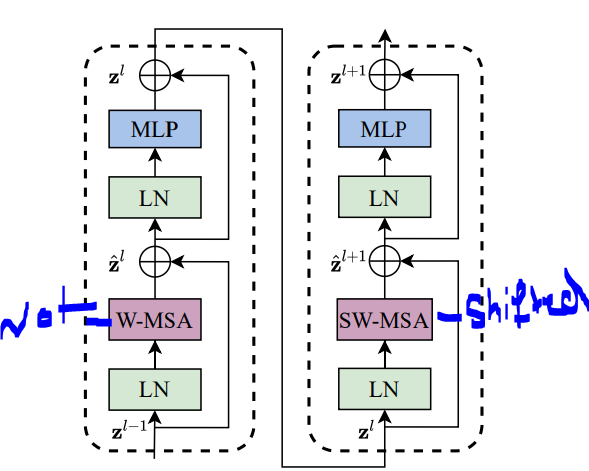

In [25]:
class SwinBlock(nn.Module):
    def __init__(self, dim, heads, head_dim, mlp_dim, shifted, window_size, relative_pos_embedding):
        super().__init__()
        self.attention_block = Residual(PreNorm(dim, WindowAttention(dim=dim,
                                                                     heads=heads,
                                                                     head_dim=head_dim,
                                                                     shifted=shifted,
                                                                     window_size=window_size,
                                                                     relative_pos_embedding=relative_pos_embedding)))
        self.mlp_block = Residual(PreNorm(dim, FeedForward(dim=dim, hidden_dim=mlp_dim)))

    def forward(self, x):
        x = self.attention_block(x)
        x = self.mlp_block(x)
        return x

# **Window Attention**

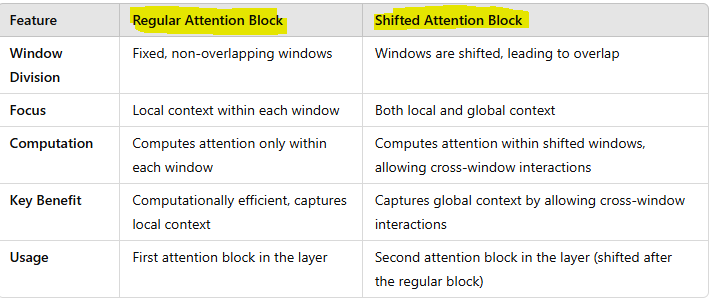

**1.Regular Window**

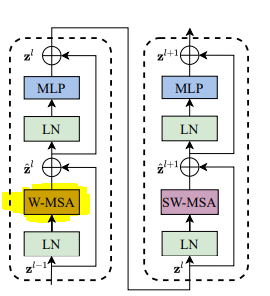

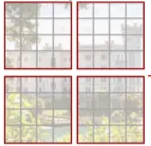

In the regular attention block, the attention mechanism is applied to non-overlapping windows of the image. This means that the image is divided into fixed-size patches (windows), and self-attention is computed within each window independently.

The attention mechanism in the regular block works by considering a fixed window of pixels (patches) and computing the relationships between all pairs of patches within that window. These patches are non-overlapping.<br>

**Benefits:**


*   Computationally efficient as it only calculates attention within smaller, local regions.

*  Reduces the computational complexity compared to global self-attention.

**Example:**
If the window size is 7x7 and the image size is 224x224, the image is divided into 32x32 non-overlapping windows (each of size 7x7), and self-attention is computed for each of those windows individually.<br>
The regular attention does not capture global relationships across different windows. It focuses only on local information within each window.

**2.Shifted Window**

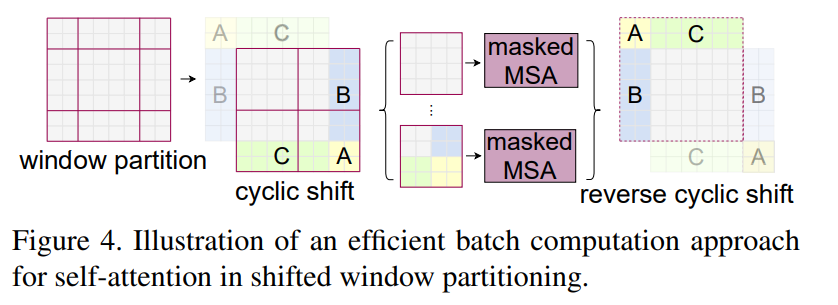

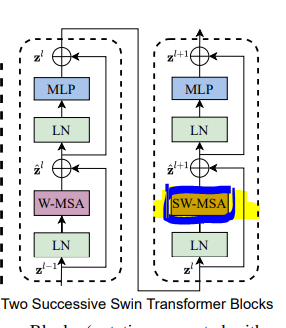

 In the shifted attention block, the attention is applied to the same non-overlapping windows as in the regular attention block, but with a twist: the windows are shifted by a fixed offset (usually by half the window size). This ensures that each window overlaps with its neighboring windows at certain locations.
 <br>
The key difference is that by shifting the windows, the model can capture global context by allowing information to propagate across adjacent windows. Essentially, the patch division is altered by shifting the grid of patches, which enables better global interactions.<br>
**Benefits:**


*   Improved Global Context: The shift allows attention to span the boundaries of adjacent windows, improving the ability to capture relationships between distant patches that the regular attention block cannot.
*   By shifting the windows, the model can cover all possible interactions between patches without increasing the computational complexity of the attention operation.

**Example:**
In the shifted attention block, if you have the same window size of 7x7, the patch grid would be shifted by half the window size (3x3). So instead of each window being disjoint (like in the regular attention block), some patches are shared between adjacent windows. This results in a more comprehensive view of the image.
<br>
The shifted attention block allows for cross-window interactions by shifting the window partitions, thereby capturing both local and global dependencies in the image.




**In the Swin Transformer**, the combination of regular attention and shifted attention is used in an alternating manner across different layers. This is what makes the Swin Transformer hierarchical, enabling it to both capture local features within small windows and global features across larger windows.


1.   **Regular Attention** (first block): This block computes self-attention within non-overlapping windows.
2.   **Shifted Attention** (second block): This block shifts the windows and computes attention again, capturing long-range dependencies.

This alternating use of regular and shifted windows helps the Swin Transformer capture a wide range of contextual information, making it very powerful for vision tasks.


In [26]:
class WindowAttention(nn.Module):
    def __init__(self, dim, heads, head_dim, shifted, window_size, relative_pos_embedding):
        super().__init__()
        inner_dim = head_dim * heads

        self.heads = heads
        self.scale = head_dim ** -0.5
        self.window_size = window_size
        self.relative_pos_embedding = relative_pos_embedding
        self.shifted = shifted

        if self.shifted:
            displacement = window_size // 2
            self.cyclic_shift = CyclicShift(-displacement)
            self.cyclic_back_shift = CyclicShift(displacement)
            self.upper_lower_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement,
                                                             upper_lower=True, left_right=False), requires_grad=False)
            self.left_right_mask = nn.Parameter(create_mask(window_size=window_size, displacement=displacement,
                                                            upper_lower=False, left_right=True), requires_grad=False)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)

        if self.relative_pos_embedding:
            self.relative_indices = get_relative_distances(window_size) + window_size - 1
            self.pos_embedding = nn.Parameter(torch.randn(2 * window_size - 1, 2 * window_size - 1))
        else:
            self.pos_embedding = nn.Parameter(torch.randn(window_size ** 2, window_size ** 2))

        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x):
        if self.shifted:
            x = self.cyclic_shift(x)

        b, n_h, n_w, _, h = *x.shape, self.heads

        qkv = self.to_qkv(x).chunk(3, dim=-1)
        nw_h = n_h // self.window_size
        nw_w = n_w // self.window_size

        q, k, v = map(
            lambda t: rearrange(t, 'b (nw_h w_h) (nw_w w_w) (h d) -> b h (nw_h nw_w) (w_h w_w) d',
                                h=h, w_h=self.window_size, w_w=self.window_size), qkv)

        dots = einsum('b h w i d, b h w j d -> b h w i j', q, k) * self.scale

        if self.relative_pos_embedding:
            dots += self.pos_embedding[self.relative_indices[:, :, 0], self.relative_indices[:, :, 1]]
        else:
            dots += self.pos_embedding

        if self.shifted:
            dots[:, :, -nw_w:] += self.upper_lower_mask
            dots[:, :, nw_w - 1::nw_w] += self.left_right_mask

        attn = dots.softmax(dim=-1)

        out = einsum('b h w i j, b h w j d -> b h w i d', attn, v)
        out = rearrange(out, 'b h (nw_h nw_w) (w_h w_w) d -> b (nw_h w_h) (nw_w w_w) (h d)',
                        h=h, w_h=self.window_size, w_w=self.window_size, nw_h=nw_h, nw_w=nw_w)
        out = self.to_out(out)

        if self.shifted:
            out = self.cyclic_back_shift(out)
        return out

# **CyclicShift**

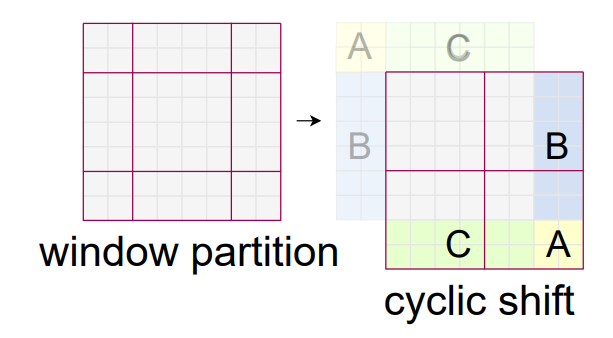

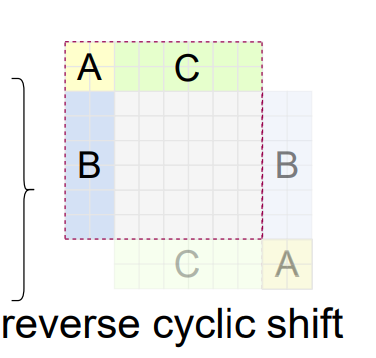

In [27]:
class CyclicShift(nn.Module):
    def __init__(self, displacement):
        super().__init__()
        self.displacement = displacement

    def forward(self, x):
        return torch.roll(x, shifts=(self.displacement, self.displacement), dims=(1, 2))

**displacemen**t: This is the shift value (in terms of number of positions) that will be applied to both the height and width of the input tensor.

**shifts**=(self.displacement, self.displacement): This specifies that the tensor should be shifted by **self.displacement positions** along both the **height (dimension 1)** and **width (dimension 2)**.

# **Create_Mask**

In [28]:
def create_mask(window_size, displacement, upper_lower, left_right):
    mask = torch.zeros(window_size ** 2, window_size ** 2)

    if upper_lower:
        mask[-displacement * window_size:, :-displacement * window_size] = float('-inf')
        mask[:-displacement * window_size, -displacement * window_size:] = float('-inf')

    if left_right:
        mask = rearrange(mask, '(h1 w1) (h2 w2) -> h1 w1 h2 w2', h1=window_size, h2=window_size)
        mask[:, -displacement:, :, :-displacement] = float('-inf')
        mask[:, :-displacement, :, -displacement:] = float('-inf')
        mask = rearrange(mask, 'h1 w1 h2 w2 -> (h1 w1) (h2 w2)')

    return mask

# **Get Relative Distances**

In [29]:
def get_relative_distances(window_size):
    indices = torch.tensor(np.array([[x, y] for x in range(window_size) for y in range(window_size)]))
    distances = indices[None, :, :] - indices[:, None, :]
    return distances

# **PreNorm**

In [30]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

# **Residual**

In [31]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

# **FeedForward**

In [32]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, x):
        return self.net(x)

In [33]:
net = SwinTransformer(
    hidden_dim=96,
    layers=(2, 2, 6, 2),
    heads=(3, 6, 12, 24),
    channels=3,
    num_classes=3,
    head_dim=32,
    window_size=7,
    downscaling_factors=(4, 2, 2, 2),
    relative_pos_embedding=True
)
dummy_x = torch.randn(1, 3, 224, 224)
logits = net(dummy_x)  # (1,3)
print(net)
print(logits)

SwinTransformer(
  (stage1): StageModule(
    (patch_partition): PatchMerging(
      (patch_merge): Unfold(kernel_size=4, dilation=1, padding=0, stride=4)
      (linear): Linear(in_features=48, out_features=96, bias=True)
    )
    (layers): ModuleList(
      (0): ModuleList(
        (0): SwinBlock(
          (attention_block): Residual(
            (fn): PreNorm(
              (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (fn): WindowAttention(
                (to_qkv): Linear(in_features=96, out_features=288, bias=False)
                (to_out): Linear(in_features=96, out_features=96, bias=True)
              )
            )
          )
          (mlp_block): Residual(
            (fn): PreNorm(
              (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (fn): FeedForward(
                (net): Sequential(
                  (0): Linear(in_features=96, out_features=384, bias=True)
                  (1): GELU(approximate='none